<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Авторы материала: Павел Нестеров. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашняя работа №4
## <center> Логистическая регрессия в задаче тегирования вопросов StackOverflow

**Надо вывести формулы, где это просится (да, ручка и бумажка), заполнить код в клетках и выбрать ответы в [веб-форме](https://docs.google.com/forms/d/1I_ticU8rpeoGJjsBUcaInpvgdxdq60hV7IcSvo4rlGo/).**

## 0. Описание задачи

В этой домашней работе мы с вами изучим и запрограммируем модель для прогнозирования тегов по тексту вопроса на базе многоклассовой логистической регрессии. В отличие от обычной постановки задачи классификации (multiclass), в данном случае один пример может принадлежать одновременно к нескольким классам (multilabel). Мы будем реализовывать онлайн версию алгоритма мультиклассовой классификации.

Мы будем использовать небольшую выборку из протеггированных вопросов с сайта StackOverflow размером в 125 тысяч примеров (около 150 Мб, скачайте по [этой](https://drive.google.com/open?id=0B4bl7YMqDnViYVo0V2FubFVhMFE) ссылке).

PS: Можно показать, что такая реализация совсем не эффективная и проще было бы использовать векторизированные вычисления. Для данного датасета так и есть. Но на самом деле подобные реализации используются в жизни, но естественно, написаны они не на Python. Например, в онлайн моделях прогнозирования [CTR](https://en.wikipedia.org/wiki/Click-through_rate) юзеру показывается баннер, затем в зависимости от наличия клика происходит обновление параметров модели. В реальной жизни параметров модели может быть несколько сотен миллионов, а у юзера из этих ста миллионов от силы сто или тысяча параметров отличны от нуля, векторизировать такие вычисления не очень эффективно. Обычно все это хранится в огромных кластерах в in-memory базах данных, а обработка пользователей происходит распределенно.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm_notebook
import pandas as pd
from collections import defaultdict

# поменяйте на свой путь
DS_FILE_NAME = '../../data/data.hw4/stackoverflow_sample_125k.tsv'
TAGS_FILE_NAME = '../../data/data.hw4/top10_tags.tsv'

In [2]:
top_tags = []
with open(TAGS_FILE_NAME, 'r') as f:
    for line in f:
        top_tags.append(line.strip())
top_tags = set(top_tags)
print(top_tags)

{'javascript', 'ios', 'c#', 'android', 'python', 'html', 'jquery', 'java', 'c++', 'php'}


## 1. Многоклассовая логистическая регрессия

Вспомним, как получается логистическая регрессия для двух классов $\left\{0, 1\right\}$, вероятность принадлежности объекта к классу $1$ выписывается по теореме Байеса:

$$\large \begin{array}{rcl}
p\left(c = 1 \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right) + p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} \\
&=& \dfrac{1}{1 + e^{-a}} \\
&=& \sigma\left(a\right)
\end{array}$$
где:
- $\vec{x}$ – вектор признаков объекта
- $\sigma$ – обозначение функции логистического сигмоида при скалярном аргументе
- $a = \log \frac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} = \sum_{i=0}^M w_i x^i$ – это отношение мы моделируем линейной функцией от признаков объекта и параметров модели

Данное выражение легко обобщить до множества из $K$ классов, изменится только знаменатель в формуле Байеса. Запишем вероятность принадлежности объекта к классу $k$:
$$\large \begin{array}{rcl}
p\left(c = k \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = k\right)p\left(c = k\right)}{\sum_{i=1}^K p\left(\vec{x} \mid c = i\right)p\left(c = i\right)} \\
&=& \dfrac{e^{z_k}}{\sum_{i=1}^{K}e^{z_i}} \\
&=& \sigma_k\left(\vec{z}\right)
\end{array}$$
где:
- $\sigma_k$ – обозначение функции softmax при векторном аргументе
- $z_k = \log p\left(\vec{x} \mid c = k\right)p\left(c = k\right) = \sum_{i=0}^M w_{ki} x^i$ – это выражение моделируется линейной функций от признаков объекта и параметров класса $k$

Для моделирования полного правдоподобия примера мы используем [категориальное распределение](https://en.wikipedia.org/wiki/Categorical_distribution), а лучше его логарифм (для удобства):

$$\large \begin{array}{rcl}
\mathcal{L} = \log p\left({\vec{x}}\right) &=& \log \prod_{i=1}^K \sigma_i\left(\vec{z}\right)^{y_i} \\
&=& \sum_{i=1}^K y_i \log \sigma_i\left(\vec{z}\right)
\end{array}$$

Получается хорошо знакомая нам функция [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) (если домножить на $-1$). Правдоподобие нужно максимизировать, а, соответственно, перекрестную энтропию нужно минимизировать. Продифференцировав по параметрам модели, мы _легко_ получим правила обновления весов для градиентного спуска, **проделайте этот вывод, если вы его не делали** (если вы вдруг сдались, то на [этом](https://www.youtube.com/watch?v=-WiR16raQf4) видео есть разбор вывода, понимание этого вам понадобится для дальнейшего выполнения задания):

$$\large \begin{array}{rcl}
\frac{\partial \mathcal{L}}{\partial w_{km}} &=& x_m \left(y_k - \sigma_k\left(\vec{z}\right)\right)
\end{array}$$

В стандартной формулировке получается, что вектор $\left(\sigma_1, \sigma_2, \ldots, \sigma_K\right)$ образует дискретное вероятностное распределение, т.е. $\sum_{i=1}^K \sigma_i = 1$. Но в нашей постановке задачи каждый пример может иметь несколько тегов или одновременно принадлежать к нескольким классам. Для этого мы немного изменим модель:
- будем считать, что все теги независимы друг от друга, т.е. каждый исход – это логистическая регрессия на два класса (либо есть тег, либо его нет), тогда вероятность наличия тега у примера запишется следующим образом (каждый тег/класс как и в многоклассовой логрегрессии имеет свой набор параметров):
$$\large p\left(\text{tag}_k \mid \vec{x}\right) = \sigma\left(z_k\right) = \sigma\left(\sum_{i=1}^M w_{ki} x^i \right)$$
- наличие каждого тега мы будем моделировать с помощью <a href="https://en.wikipedia.org/wiki/Bernoulli_distribution">распределения Бернулли</a>

Ваше первое задание –  записать упрощенное выражение логарифма правдоподобия примера с признаками $\vec{x}$. Как правило, многие алгоритмы оптимизации имеют интерфейс для минимизации функции, мы последуем этой же традиции, и домножим полученное выражение на $-1$, а во второй части выведем формулы для минимизации полученного выражения.

<font color="red">Варианты ответа:</font>
1. $\large -\mathcal{L} = -\sum_{i=1}^M y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$
2. $\large -\mathcal{L} = -\sum_{i=1}^K y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$
3. $\large -\mathcal{L} = -\sum_{i=1}^K z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$
4. $\large -\mathcal{L} = -\sum_{i=1}^M z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$

## 2. Вывод формулы обновления весов

В качестве второго задания вам предоставляется возможность вывести формулу градиента для $-\mathcal{L}$.

<font color="red">Варианты ответа:</font>:
1. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(\sigma\left(z_k\right) - y_k\right)$
2. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(y_k - \sigma\left(z_k\right)\right)$
3. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(\sigma\left(z_k\right)x_m - y_k\right)$
4. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(y_k - \sigma\left(z_k\right)x_m\right)$

## 3. Имплементация базовой модели

Вам предлагается каркас класса модели, разберите его внимательно, обращайте внимание на комментарии. Затем заполните пропуски, запустите полученную модель и ответьте на проверочный вопрос.

Как вы могли уже заметить, при обновлении веса $w_{km}$ используется значение признака $x_m$, который равен $0$ если слова с индексом $m$ нет в предложении, и больше нуля, если такое слово есть. Соответственно, при вычислении линейной комбинации $z$ весов модели и признаков примера необходимо учитывать только ненулевые признаки объекта.

Подсказка:
- если реализовывать вычисление сигмоида так же, как в формуле, то при большом отрицательном значении $z$ вычисление $e^{-z}$ превратится в очень большое число, которое вылетит за допустимые пределы
- в то же время $e^{-1}$ от большого положительного $z$ будет нулем
- воспользуйтесь свойствами функции $\sigma$ для того, чтобы пофиксить эту ошибку

In [18]:
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     lmbda=0):
        
        self._loss = []
        n = 0
        jaccard_loss = 0
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0
                predicted_tags = set()
                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = 1.0 / (1.0 + np.exp(-z)) if z > 0 else \
                            1.0 - 1.0 / (1.0 + np.exp(z))
    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sample_loss += -np.log(np.max([tolerance, sigma])) if y == 1 else \
                                   -np.log(np.max([tolerance, 1 - sigma]))
                    if sigma > 0.9:
                        predicted_tags.add(tag)
                 
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        dLdw = y - sigma

                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:
                            l2 = 0
                            if lmbda > 0:
                                l2 = self._w[tag][self._vocab[word]]
                            self._w[tag][self._vocab[word]] -= (learning_rate*(-dLdw + lmbda * l2))
                        self._b[tag] -= -learning_rate*dLdw
                    
                n += 1
                #if n == 20000:
                #    break
                if n % 1000 == 0:
                    print(tags, predicted_tags)
                if n > top_n_train:
                    jaccard_loss += len(tags & predicted_tags) * 1.0 / len(tags | predicted_tags)
                self._loss.append(sample_loss)
        return jaccard_loss / (n - top_n_train)

In [19]:
# создадим эксемпляр модели и пройдемся по датасету
model = LogRegressor()
acc = model.iterate_file()

{'jquery'} {'jquery', 'c#', 'javascript'}
{'java'} {'c#'}
{'android'} {'android'}
{'ios'} {'ios', 'c#'}
{'android'} {'android'}
{'javascript'} {'javascript'}
{'jquery', 'javascript'} {'jquery'}
{'jquery'} {'jquery'}
{'c#'} {'c#'}
{'android'} {'android'}
{'c#'} {'c#'}
{'c#'} {'c#'}
{'java'} {'java'}
{'python'} {'html', 'android', 'javascript'}
{'python'} set()
{'java'} {'java'}
{'ios'} {'ios', 'c#'}
{'html'} {'jquery', 'html'}
{'javascript'} set()
{'java'} set()
{'php'} {'php'}
{'java'} set()
{'c#', 'javascript'} set()
{'ios'} {'ios', 'android', 'javascript'}
{'ios'} {'ios'}
{'c#'} {'c#'}
{'php'} {'php'}
{'php'} {'php'}
{'c#'} {'c#'}
{'java'} {'php'}
{'jquery', 'javascript'} {'jquery', 'javascript'}
{'c#'} {'c#', 'php'}
{'android'} {'android'}
{'java'} set()
{'java'} {'java'}
{'c#'} {'java', 'c#'}
{'javascript'} {'jquery', 'html', 'javascript'}
{'c#'} set()
{'jquery', 'javascript'} {'c#', 'php', 'javascript'}
{'android'} {'android'}
{'php'} {'php'}
{'php'} {'php'}
{'java'} {'c#'}
{'jque

Проверим, действительно ли значение отрицательного логарифмического правдоподобия уменьшалось. Так как мы используем стохастический градентный спуск, не стоит ожидать плавного падения функции ошибки. Мы воспользуемся скользящим средним с окном в 10 000 примеров, чтобы хоть как то сгладить график.

[]

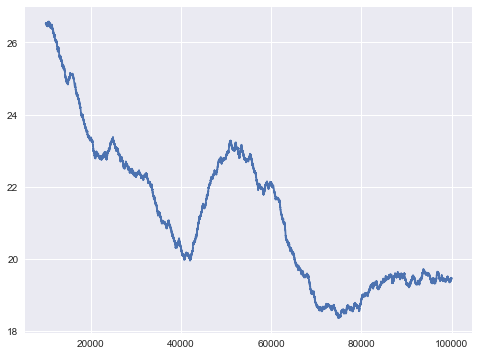

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean())
plt.grid()
plt.plot()

In [23]:
print('Mean of the loss function on the last 10k train samples: %0.2f' % np.mean(model._loss[-35000:-25000]))

Mean of the loss function on the last 10k train samples: 19.47


Вычислите среднее значение функции стоимости на последних 10 000 примеров тренировочного набора, к какому из значений ваш ответ ближе всего?

<font color="red">Варианты ответа:</font>:
1. 17.54
2. 18.64
3. 19.74
4. 20.84

## 4. Тестирование модели

В базовой модели первые 100 000 строк используются для обучения, а оставшиеся – для тестирования. Как вы можете заметить, значение отрицательного логарифмического правдоподобия не очень информативно, хоть и позволяет сравнивать разные модели. В качестве четвертого задания вам необходимо модифицировать базовую модель таким образом, чтобы метод `iterate_file` возвращал значение _точности_ на тестовой части набора данных. 

Точность определим следующим образом:
- считаем, что тег у вопроса присутствует, если спрогнозированная вероятность тега больше 0.9
- точность одного примера расчитывается как [коэффициент Жаккара](https://ru.wikipedia.org/wiki/Коэффициент_Жаккара) между множеством настоящих тегов и предсказанных моделью
  - например, если у примера настоящие теги ['html', 'jquery'], а по версии модели ['ios', 'html', 'java'], то коэффициент Жаккара будет равен |['html', 'jquery'] $\cap$ ['ios', 'html', 'java']| / |['html', 'jquery'] $\cup$ ['ios', 'html', 'java']| = |['html']| / |['jquery', 'ios', 'html', 'java']| = 1/4
- метод `iterate_file` возвращает **среднюю** точность на тестовом наборе данных

In [ ]:
# Обновите определение класса LogRegressor
# Ваш код здесь

In [24]:
#model = LogRegressor()
#acc = model.iterate_file()
# выведем полученное значение с точностью до двух знаков
print('%0.2f' % acc)

0.59


Ответьте на вопрос,  к какому значению ближе всего полученное значение точности?
<font color="red">Варианты ответа:</font>:
1. 0.39
2. 0.49
3. 0.59
4. 0.69

## 5. $L_2$-регуляризация

В качестве пятого задания вам необходимо добавить в класс `LogRegressor` поддержку $L_2$-регуляризации. В методе `iterate_file` должен появиться параметр `lmbda=0.01` со значением по умолчанию. С учетом регуляризации новая функция стоимости примет вид:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \frac{\lambda}{2} \sum_{k=1}^K\sum_{i=1}^M w_{ki}^2
\end{array}$$

Градиент первого члена суммы мы уже вывели, а для второго он имеет вид:

$$\large \begin{array}{rcl}
\frac{\partial}{\partial w_{ki}} \frac{\lambda}{2} R\left(W\right) &=& \lambda w_{ki}
\end{array}$$

Если мы на каждом примере будем делать честное обновление всех весов, то все очень замедлится, ведь нам придется на каждой итерации пробегать по всем словам словаря. В ущерб теоретической точности вы используем грязный трюк: мы будем регуляризаровать только те слова, которые присутствуют в текущем предложении. Не забывайте, что смещение не регуляризируется. `sample_loss` тоже должен остаться без изменений.

In [ ]:
# Обновите определение класса LogRegressor
# Ваш код здесь

{'jquery'} {'jquery', 'c#', 'javascript'}
{'java'} {'javascript'}
{'android'} {'android'}
{'ios'} {'ios'}
{'android'} {'android'}
{'javascript'} {'javascript'}
{'jquery', 'javascript'} {'jquery', 'javascript'}
{'jquery'} {'jquery', 'c#', 'php'}
{'c#'} {'c#'}
{'android'} {'android'}
{'c#'} {'java'}
{'c#'} {'c#'}
{'java'} set()
{'python'} {'android', 'javascript'}
{'python'} {'python'}
{'java'} set()
{'ios'} {'ios', 'javascript'}
{'html'} {'html'}
{'javascript'} set()
{'java'} {'android'}
{'php'} {'html', 'php'}
{'java'} set()
{'c#', 'javascript'} set()
{'ios'} {'ios', 'android', 'php'}
{'ios'} {'ios'}
{'c#'} set()
{'php'} {'php'}
{'php'} {'php'}
{'c#'} {'c#'}
{'java'} set()
{'jquery', 'javascript'} {'javascript'}
{'c#'} {'c#'}
{'android'} {'android'}
{'java'} {'java', 'android', 'javascript'}
{'java'} {'java'}
{'c#'} {'java', 'c#'}
{'javascript'} {'jquery', 'javascript'}
{'c#'} set()
{'jquery', 'javascript'} {'php', 'javascript'}
{'android'} {'android'}
{'php'} set()
{'php'} {'php'}
{'j

[]

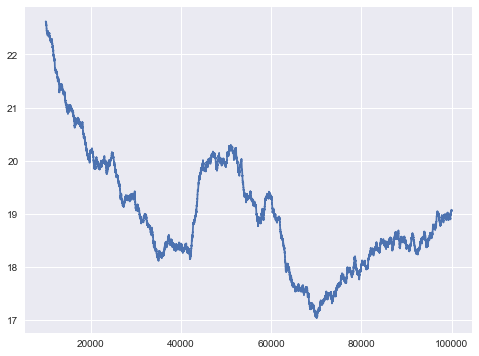

In [25]:
model = LogRegressor()
acc = model.iterate_file(lmbda=0.01)
print('%0.2f' % acc)
plt.figure(figsize=(8, 6))
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean())
plt.grid()
plt.plot()

Ответьте на вопрос, к какому значению ближе всего полученное значение точности?
<font color="red">Варианты ответа:</font>:
1. 0.3
2. 0.35
3. 0.4
4. 0.52

## 6. ElasticNet регуляризация, вывод
Помимо $L_2$ регуляризации, часто используется $L_1$ регуляризация.

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \lambda \sum_{k=1}^K\sum_{i=1}^M \left|w_{ki}\right|
\end{array}$$

Если линейно объединить $L_1$ и $L_2$ регуляризацию, то полученный тип регуляризации называется ElasticNet:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \lambda R\left(W\right) \\
&=& -\mathcal{L} + \lambda \left(\gamma \sum_{k=1}^K\sum_{i=1}^M w_{ki}^2 + \left(1 - \gamma\right) \sum_{k=1}^K\sum_{i=1}^M \left|w_{ki}\right| \right)
\end{array}$$
- где $\gamma \in \left[0, 1\right]$

В качестве шестого вопроса вам предлагается вывести формулу градиента ElasticNet регуляризации (не учитывая $-\mathcal{L}$). 

<font color="red">Варианты ответа:</font>:
1. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) w_{ki}\right)$ 
2. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma \left|w_{ki}\right| + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$
3. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$
4. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(\gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$

## 7. ElasticNet регуляризация, имплементация

В качестве седьмой задачи, вам предлается изменить класс `LogRegressor` таким образом, чтобы метод `iterate_file` принимал два параметра со значениями по умолчанию `lmbda=0.0002` и `gamma=0.1`. Сделайте один проход по датасету с включенной ElasticNet регуляризацией и заданными значениями по умолчанию и ответьте на вопрос.

In [15]:
from collections import Counter

# Обновите определение класса LogRegressor
# Ваш код здесь
class LogRegressorElasticNet():
    
    """Конструктор
    
    Параметры
    ----------
    tags : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)

    def filter_vocab(self, fname=DS_FILE_NAME, total=125000, top_n_train=100000, n=10000):
        c = Counter()
        k = 0
        with open(fname, 'r') as f:            
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                sentence = sentence.split(' ')
                if k < top_n_train:
                    c.update(sentence)
                k += 1
        top_words = {}
        for word, _ in sorted(c.items(), key=lambda x: -x[1])[:n]:
            if word in self._vocab:
                top_words[word] = self._vocab[word]
        self._vocab = top_words

            
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     lmbda=0.0002,
                     gamma=0.1,
                     update_vocab=True):
        
        self._loss = []
        n = 0
        jaccard_loss = 0
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0
                predicted_tags = set()
                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    z = self._b[tag]
   
                    for word in sentence:
                        if update_vocab is False and word not in self._vocab:
                            continue
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sigma = 1.0 / (1.0 + np.exp(-z)) if z > 0 else \
                            1.0 - 1.0 / (1.0 + np.exp(z))
    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    sample_loss += -np.log(np.max([tolerance, sigma])) if y == 1 else \
                                   -np.log(np.max([tolerance, 1 - sigma]))
                    if sigma > 0.9:
                        predicted_tags.add(tag)
                 
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        dLdw = y - sigma

                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:
                            if word not in self._vocab:
                                continue
                            w = self._w[tag][self._vocab[word]]
                            l2 = 2 * gamma * w
                            l1 = (1 - gamma) * np.sign(w)
                            self._w[tag][self._vocab[word]] -= (learning_rate * (-dLdw + lmbda * (l1 + l2)))
                        self._b[tag] -= -learning_rate*dLdw
                    
                n += 1
                #if n == 2000:
                #    break
                if n % 1000 == 0:
                    print(n, tags, predicted_tags)
                if n > top_n_train:
                    jaccard_loss += len(tags & predicted_tags) * 1.0 / len(tags | predicted_tags)
                self._loss.append(sample_loss)
        return jaccard_loss / (n - top_n_train)
    
    def predict_proba(self, sentence):
        result = dict()
        for tag in self._tags:
            z = self._b[tag]
            for word in sentence.lower().split(' '):
                if word in self._vocab:
                    z += self._w[tag][self._vocab[word]]
            sigma = 1.0 / (1.0 + np.exp(-z)) if z > 0 else \
                    1.0 - 1.0 / (1.0 + np.exp(z))        
            result[tag] = sigma
        return result

In [10]:
model = LogRegressorElasticNet()
acc = model.iterate_file()
print('%0.2f' % acc)

1000 {'jquery'} {'javascript'}
2000 {'java'} {'c#', 'java'}
3000 {'android'} {'android'}
4000 {'ios'} {'c#', 'ios'}
5000 {'android'} {'android'}
6000 {'javascript'} {'javascript'}
7000 {'jquery', 'javascript'} {'javascript', 'jquery', 'php'}
8000 {'jquery'} {'jquery', 'python'}
9000 {'c#'} {'ios'}
10000 {'android'} {'android'}
11000 {'c#'} set()
12000 {'c#'} {'c#'}
13000 {'java'} set()
14000 {'python'} {'html', 'android', 'javascript'}
15000 {'python'} set()
16000 {'java'} {'java'}
17000 {'ios'} {'ios'}
18000 {'html'} {'jquery', 'html'}
19000 {'javascript'} {'javascript'}
20000 {'java'} {'java'}
21000 {'php'} {'c#'}
22000 {'java'} set()
23000 {'c#', 'javascript'} set()
24000 {'ios'} {'ios', 'android'}
25000 {'ios'} {'ios'}
26000 {'c#'} {'c#'}
27000 {'php'} {'php'}
28000 {'php'} {'php'}
29000 {'c#'} {'c#'}
30000 {'java'} {'php'}
31000 {'jquery', 'javascript'} {'javascript'}
32000 {'c#'} {'c#', 'php'}
33000 {'android'} {'android'}
34000 {'java'} {'java'}
35000 {'java'} {'java'}
36000 {'c

[]

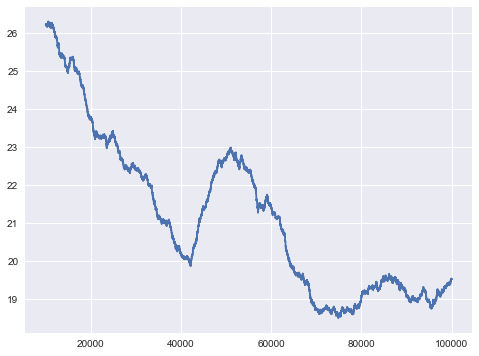

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean())
plt.grid()
plt.plot()

Ответьте на вопрос,  к какому значению ближе всего полученное значение точности:
<font color="red">Варианты ответа:</font>
1. 0.59
2. 0.69
3. 0.79
4. 0.82

## 8. Самые важные слова для тега

Прелесть линейных моделей в том, что они легко интерпретируемы. Вам предлагается вычислить, какие слова вносят наибольший вклад в вероятность каждого из тегов. А затем ответьте на контрольный вопрос.

In [12]:
# Ваш код здесь
inverseVoc = dict([(v, k) for k, v in model._vocab.items()])
for tag in model._tags:
    print(tag)
    mainTags = [(inverseVoc[e[0]], e[1]) for e in sorted(model._w[tag].items(), key=lambda x: -x[1])[:5]]
    print(mainTags)
    if tag not in set([e[0] for e in mainTags]):
        print(tag)
    print()

c#
[('writeline', 26.017583270194006), ('binding', 23.309214372227014), ('linq', 21.549397861680678), ('net', 19.227046169181303), ('runat', 19.178701716490664)]
c#

jquery
[('jquery', 94.044563112868474), ('ready', 31.714440177642764), ('span', 31.538516437966795), ('ajax', 28.790173626482986), ('val', 23.315201745913402)]

ios
[('ios', 46.640375885437038), ('dylib', 31.925458798995418), ('nsstring', 29.13305436548707), ('nil', 28.260565684644071), ('uiview', 25.625261357145952)]

android
[('android', 57.88851150890487), ('activity', 28.073533082998022), ('art', 25.661102434480288), ('imgsrv', 25.282719342648132), ('29297', 25.282719342648132)]

php
[('php', 74.858594424229935), ('x5c', 44.552326597122224), ('_post', 42.878584069108008), ('echo', 40.930439179984894), ('125', 39.629133107292979)]

javascript
[('javascript', 62.217233385514497), ('x20', 50.639502751641437), ('125', 37.044147761289715), ('3', 36.663144913444221), ('x30', 35.368687771275198)]

java
[('hibernate', 30.22501

Для многих тегов наличие самого тега в предложении является важным сигналом, у многих сам тег является самым сильным сигналом, что неудивительно. Для каких из тегов само название тега не входит в топ-5 самых важных?

<font color="red">Варианты ответа:</font>
1. java, c#
2. php, javascript
3. html, jquery
4. ios, android

## 9. Сокращаем размер словаря
Сейчас количество слов в словаре около 90 000, если бы это была выборка из 10 миллионов вопросов с сайта StackOverflow, то размер словаря был бы миллионов 10. Регуляризировать модель можно не только изящно математически, но и топорно, например, ограничить размер словаря. Вам предоставляется возможность внести следующие изменения в класс `LogRegressor`:
- добавить в метод `iterate_file` еще один аргумент со значением по умолчанию `update_vocab=True`
- при `update_vocab=True` разрешать добавлять слова в словарь в режиме обучения
- при `update_vocab=False` игнорировать слова не из словаря
- добавить в класс метод `filter_vocab(n=10000)`, который оставит в словаре только топ-n самых популярных слов

1000 {'jquery'} {'javascript'}
2000 {'java'} {'java', 'c#'}
3000 {'android'} {'android'}
4000 {'ios'} {'ios', 'c#'}
5000 {'android'} {'android'}
6000 {'javascript'} {'javascript'}
7000 {'javascript', 'jquery'} {'javascript', 'jquery', 'php'}
8000 {'jquery'} {'python', 'jquery'}
9000 {'c#'} {'ios'}
10000 {'android'} {'android'}
11000 {'c#'} set()
12000 {'c#'} {'c#'}
13000 {'java'} set()
14000 {'python'} {'javascript', 'html', 'android'}
15000 {'python'} set()
16000 {'java'} {'java'}
17000 {'ios'} {'ios'}
18000 {'html'} {'jquery', 'html'}
19000 {'javascript'} {'javascript'}
20000 {'java'} {'java'}
21000 {'php'} {'c#'}
22000 {'java'} set()
23000 {'javascript', 'c#'} set()
24000 {'ios'} {'ios', 'android'}
25000 {'ios'} {'ios'}
26000 {'c#'} {'c#'}
27000 {'php'} {'php'}
28000 {'php'} {'php'}
29000 {'c#'} {'c#'}
30000 {'java'} {'php'}
31000 {'javascript', 'jquery'} {'javascript'}
32000 {'c#'} {'c#', 'php'}
33000 {'android'} {'android'}
34000 {'java'} {'java'}
35000 {'java'} {'java'}
36000 {'c

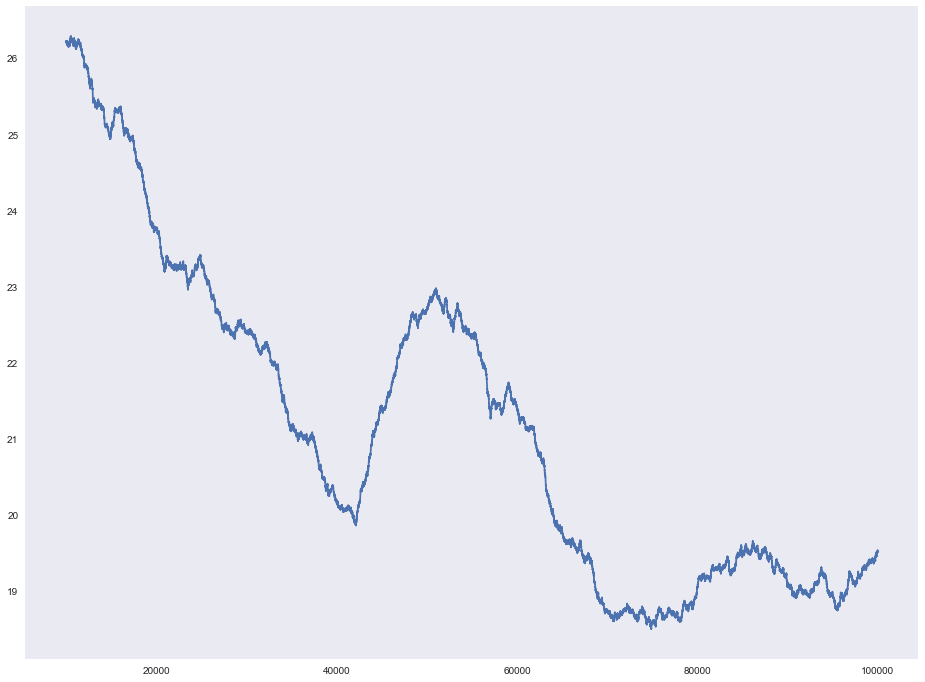

In [16]:
model = LogRegressorElasticNet()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [17]:
# оставим только топ 10 000 слов
model.filter_vocab(n=10000)
print(len(model._vocab))


10000


1000 {'jquery'} {'javascript', 'jquery', 'html'}
2000 {'java'} {'java'}
3000 {'android'} {'java', 'android'}
4000 {'ios'} {'javascript', 'ios'}
5000 {'android'} {'android'}
6000 {'javascript'} {'javascript'}
7000 {'javascript', 'jquery'} {'javascript', 'jquery'}
8000 {'jquery'} {'jquery', 'ios'}
9000 {'c#'} {'c#'}
10000 {'android'} {'android'}
11000 {'c#'} {'c#'}
12000 {'c#'} {'c#'}
13000 {'java'} set()
14000 {'python'} {'javascript', 'python', 'html'}
15000 {'python'} {'javascript'}
16000 {'java'} set()
17000 {'ios'} {'ios'}
18000 {'html'} {'jquery', 'html'}
19000 {'javascript'} {'javascript'}
20000 {'java'} set()
21000 {'php'} set()
22000 {'java'} {'android'}
23000 {'javascript', 'c#'} {'jquery'}
24000 {'ios'} {'ios', 'android'}
25000 {'ios'} {'ios'}
26000 {'c#'} {'c#'}
27000 {'php'} {'php'}
28000 {'php'} {'php'}
29000 {'c#'} {'c#'}
30000 {'java'} {'php'}
31000 {'javascript', 'jquery'} {'javascript', 'jquery'}
32000 {'c#'} {'c#'}
33000 {'android'} {'java', 'android'}
34000 {'java'} {

[]

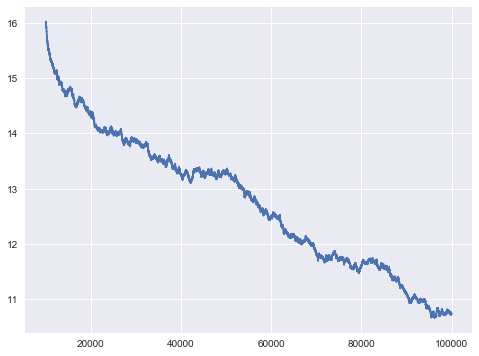

In [18]:
# сделаем еще одну итерацию по датасету, уменьшив скорость обучения в 10 раз
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)
plt.figure(figsize=(8, 6))
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean())
plt.grid()
plt.plot()

Ответьте на вопрос,  к какому значению ближе всего полученное значение точности:
<font color="red">Варианты ответа:</font>
1. 0.48
2. 0.58
3. 0.68
4. 0.78

## 10. Прогнозирование тегов для новых вопросов

В завершение сегодняшней домашки, вам предлагается реализовать метод `predict_proba`, который принимает строку,  содержащую вопрос, а возвращает список предсказанных тегов вопроса с их вероятностями.

In [ ]:
# Обновите определение класса LogRegressor
# Ваш код здесь

In [4]:
model = LogRegressorElasticNet()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)
model.filter_vocab(n=10000)
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)

1000 {'jquery'} {'javascript'}
2000 {'java'} {'java', 'c#'}
3000 {'android'} {'android'}
4000 {'ios'} {'ios', 'c#'}
5000 {'android'} {'android'}
6000 {'javascript'} {'javascript'}
7000 {'javascript', 'jquery'} {'php', 'jquery', 'javascript'}
8000 {'jquery'} {'jquery', 'python'}
9000 {'c#'} {'ios'}
10000 {'android'} {'android'}
11000 {'c#'} set()
12000 {'c#'} {'c#'}
13000 {'java'} set()
14000 {'python'} {'html', 'android', 'javascript'}
15000 {'python'} set()
16000 {'java'} {'java'}
17000 {'ios'} {'ios'}
18000 {'html'} {'html', 'jquery'}
19000 {'javascript'} {'javascript'}
20000 {'java'} {'java'}
21000 {'php'} {'c#'}
22000 {'java'} set()
23000 {'javascript', 'c#'} set()
24000 {'ios'} {'android', 'ios'}
25000 {'ios'} {'ios'}
26000 {'c#'} {'c#'}
27000 {'php'} {'php'}
28000 {'php'} {'php'}
29000 {'c#'} {'c#'}
30000 {'java'} {'php'}
31000 {'javascript', 'jquery'} {'javascript'}
32000 {'c#'} {'php', 'c#'}
33000 {'android'} {'android'}
34000 {'java'} {'java'}
35000 {'java'} {'java'}
36000 {'c

1000 {'jquery'} {'html', 'jquery', 'javascript'}
2000 {'java'} {'java'}
3000 {'android'} {'java', 'android'}
4000 {'ios'} {'ios', 'javascript'}
5000 {'android'} {'android'}
6000 {'javascript'} {'javascript'}
7000 {'javascript', 'jquery'} {'jquery', 'javascript'}
8000 {'jquery'} {'ios', 'jquery'}
9000 {'c#'} {'c#'}
10000 {'android'} {'android'}
11000 {'c#'} {'c#'}
12000 {'c#'} {'c#'}
13000 {'java'} set()
14000 {'python'} {'html', 'javascript', 'python'}
15000 {'python'} {'javascript'}
16000 {'java'} set()
17000 {'ios'} {'ios'}
18000 {'html'} {'html', 'jquery'}
19000 {'javascript'} {'javascript'}
20000 {'java'} set()
21000 {'php'} set()
22000 {'java'} {'android'}
23000 {'javascript', 'c#'} {'jquery'}
24000 {'ios'} {'android', 'ios'}
25000 {'ios'} {'ios'}
26000 {'c#'} {'c#'}
27000 {'php'} {'php'}
28000 {'php'} {'php'}
29000 {'c#'} {'c#'}
30000 {'java'} {'php'}
31000 {'javascript', 'jquery'} {'jquery', 'javascript'}
32000 {'c#'} {'c#'}
33000 {'android'} {'java', 'android'}
34000 {'java'} {

In [19]:
sentence = ("I want to improve my coding skills, so I have planned write " +
            "a Mobile Application.need to choose between Apple's iOS or Google's Android." +
            " my background: I have done basic programming in .Net,C/C++,Python and PHP " +
            "in college, so got OOP concepts covered. about my skill level, I just know " +
            "concepts and basic syntax. But can't write complex applications, if asked :(" +
            " So decided to hone my skills, And I wanted to know which is easier to " +
            "learn for a programming n00b. A) iOS which uses Objective C B) Android " + 
            "which uses Java. I want to decide based on difficulty level")

In [30]:
for e in sorted(model.predict_proba(sentence).items(), key=lambda x: -x[1]):
    print(e)

('ios', 1.0)
('php', 0.99940006454276553)
('android', 4.6988390955959858e-10)
('javascript', 0.0)
('python', 0.0)
('c#', 0.0)
('html', 0.0)
('jquery', 0.0)
('java', 0.0)
('c++', 0.0)


In [28]:
import re
for e in sorted(model.predict_proba(' '.join(re.findall("\w+", sentence, re.UNICODE))).items(), key=lambda x: -x[1]):
    print(e)

('ios', 0.7812271801702384)
('android', 2.6490474007712095e-06)
('javascript', 0.0)
('python', 0.0)
('php', 0.0)
('c#', 0.0)
('html', 0.0)
('jquery', 0.0)
('java', 0.0)
('c++', 0.0)


In [25]:
def predict_proba(model, sentence): 
    result = dict()
    for tag in model._tags:
        z = model._b[tag]
        for word in sentence.split(' '):
            if word in model._vocab:
                z += model._w[tag][model._vocab[word]]
        sigma = 1.0 / (1.0 + np.exp(-z)) if z > 0 else \
                1.0 - 1.0 / (1.0 + np.exp(z))        
        result[tag] = sigma 
    return result

In [26]:
for e in sorted(predict_proba(model, sentence).items(), key=lambda x: -x[1]):
    print(e)

('java', 0.99999974727060736)
('c#', 0.04947104484582765)
('python', 0.024673895108592525)
('javascript', 0.017308355976665246)
('ios', 4.831287891970959e-08)
('php', 4.1054077914992604e-09)
('c++', 2.6512125828048738e-13)
('android', 2.1183055309847987e-13)
('html', 0.0)
('jquery', 0.0)


In [27]:
import re
for e in sorted(predict_proba(model, ' '.join(re.findall("\w+", sentence, re.UNICODE))).items(), key=lambda x: -x[1]):
    print(e)

('java', 0.99999999999327183)
('javascript', 0.050566293093480263)
('python', 4.8537068210174894e-06)
('c#', 4.2253387944057863e-07)
('php', 1.7948058261829658e-08)
('ios', 9.8325791952902364e-12)
('android', 1.3322676295501878e-15)
('html', 0.0)
('jquery', 0.0)
('c++', 0.0)


Ответьте на вопрос, какой или какие теги ассоциируются с данным вопросом, если порог принятия равен $0.9$?:
<font color="red">Варианты ответа:</font>
1. android
2. ios
3. ios, php
4. c#, c++, ods